# Textures and local image statistics

In [1]:
import os
import nibabel
import numpy as np
import matplotlib.pyplot as plt

from math import ceil

from ia_mri_tools.features import textures
from ia_mri_tools.pyramid import gaussian_pyramid, dog_pyramid, laplacian_pyramid, gradient_pyramid

% matplotlib inline
plt.style.use('seaborn-white')


def im_show(h, n, m, i, title=None, colorbar=True, vmin=-100, vmax=100):
    plt.subplot(n, m, i)
    plt.imshow(h[:, ::-1].transpose(), cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if title:
        plt.title(title)
    if colorbar:
        plt.colorbar()


def im_show_scale(h, n, m, i, title=None, colorbar=True, pmin=2, pmax=98):
    plt.subplot(n, m, i)
    plt.imshow(h[:, ::-1].transpose(), cmap='gray', vmin=np.percentile(h, pmin), vmax=np.percentile(h, pmax))
    plt.axis('off')
    if title:
        plt.title(title)
    if colorbar:
        plt.colorbar()


def load_data(dset, z=None, data_path='data/HCP/100307'):
    """

    :param dset: string 'T1', 'T2', 'T1r', 'T2r', or 'aparc+aseg'
    :param z: integer slice number
    :param data_path: path to the data
    :return: data as a numpy array
    """

    if dset == 'T1':
        dset_path = os.path.join(data_path, 'T1w_acpc_dc.nii.gz')
    elif dset == 'T2':
        dset_path = os.path.join(data_path, 'T2w_acpc_dc.nii.gz')
    elif dset == 'T1r':
        dset_path = os.path.join(data_path, 'T1w_acpc_dc_restore.nii.gz')
    elif dset == 'T2r':
        dset_path = os.path.join(data_path, 'T2w_acpc_dc_restore.nii.gz')
    elif dset == 'aparc+aseg':
        dset_path = os.path.join(data_path, 'aparc+aseg.nii.gz')
    else:
        raise NameError('Unknown data set name.')

    # read the volume
    data = nibabel.load(dset_path).get_data()
    # select a slice if needed
    if z:
        data = data[:, :, z]

    return data



## An example image

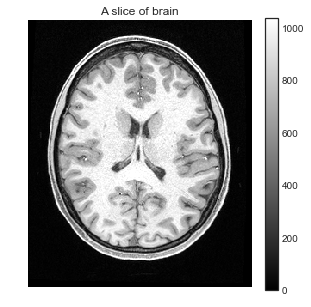

In [2]:
# Load a slice from an image and convert to doubles.
data = load_data('T1r', z=120).astype(np.double)

plt.figure(figsize=[5,5])
im_show_scale(data, 1,1,1, 'A slice of brain')

## Gaussian Pyramid

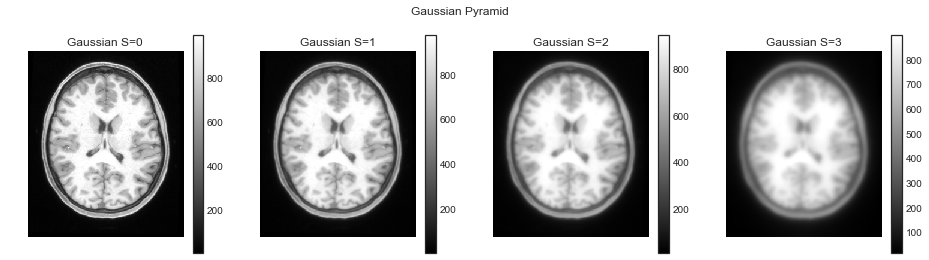

In [3]:
gauss_pyr = gaussian_pyramid(data, nlevels=4)
ncols = len(gauss_pyr)

plt.figure(figsize=[ncols*4,4])
plt.suptitle('Gaussian Pyramid')
for n in range(ncols):
    im_show_scale(gauss_pyr[n], 1,ncols,n+1, 'Gaussian S={}'.format(n))


## DoG Pyramid

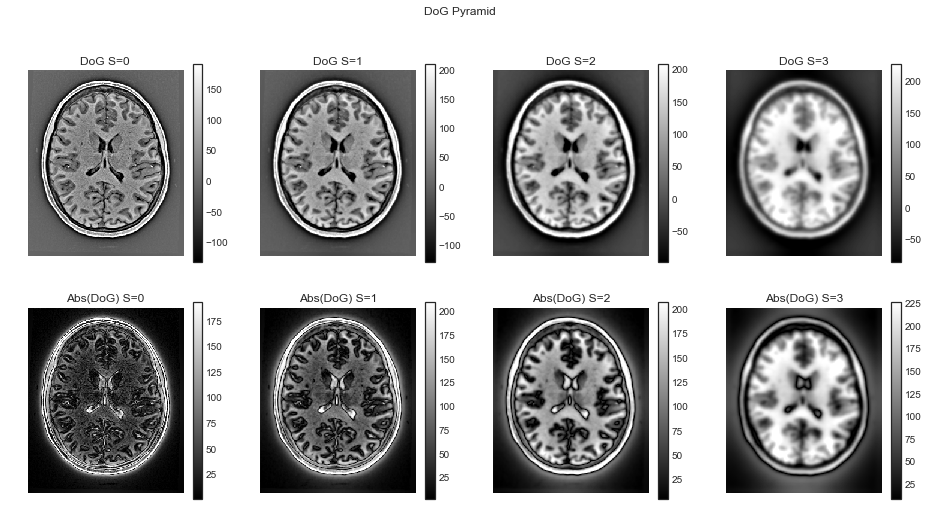

In [4]:
dog_pyr = dog_pyramid(data, nlevels=4)
ncols = len(dog_pyr)

plt.figure(figsize=[ncols*4,8])
plt.suptitle('DoG Pyramid')
for n in range(ncols):
    im_show_scale(dog_pyr[n], 2,ncols,n+1, 'DoG S={}'.format(n))
    im_show_scale(np.abs(dog_pyr[n]), 2,ncols,ncols+n+1, 'Abs(DoG) S={}'.format(n))

## Laplacian Pyramid

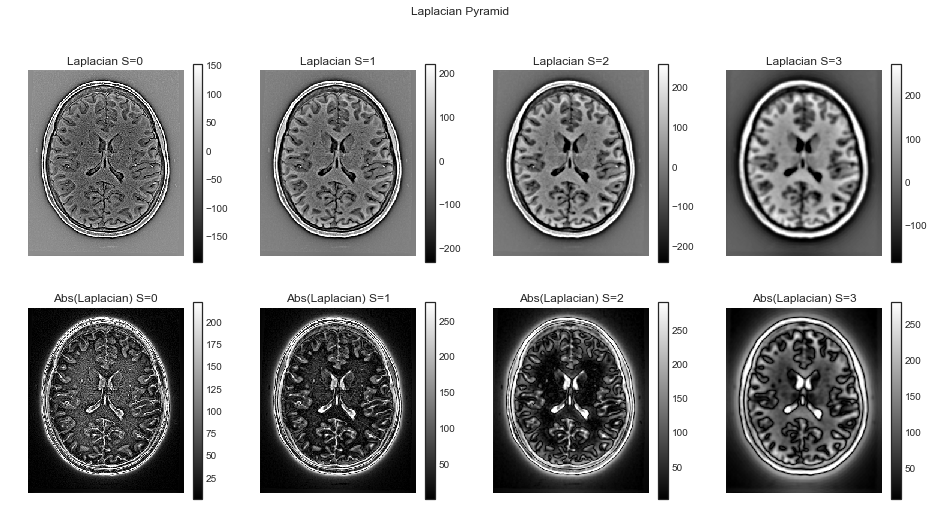

In [5]:
lap_pyr = laplacian_pyramid(data, nlevels=4)
ncols = len(lap_pyr)

plt.figure(figsize=[ncols*4,8])
plt.suptitle('Laplacian Pyramid')
for n in range(ncols):
    im_show_scale(lap_pyr[n], 2,ncols,n+1, 'Laplacian S={}'.format(n))
    im_show_scale(np.abs(lap_pyr[n]), 2,ncols,ncols+n+1, 'Abs(Laplacian) S={}'.format(n))    

## High Pass Filter

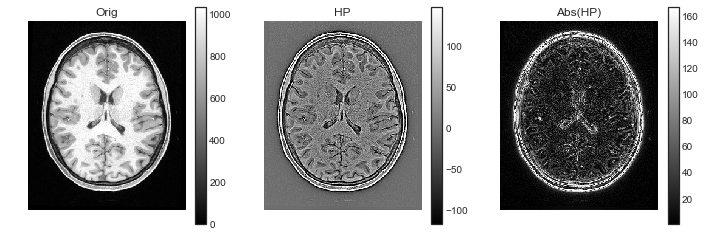

In [6]:
plt.figure(figsize=[3*4,4])
im_show_scale(data, 1,3,1, 'Orig')
im_show_scale(data-gauss_pyr[0], 1,3,2, 'HP')
im_show_scale(np.abs(data-gauss_pyr[0]), 1,3,3, 'Abs(HP)')

## Gradient Pyramid

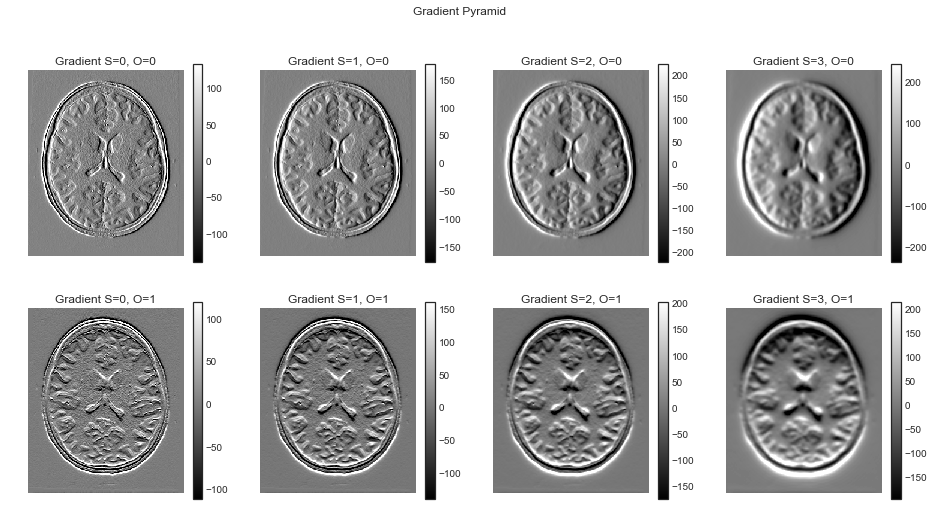

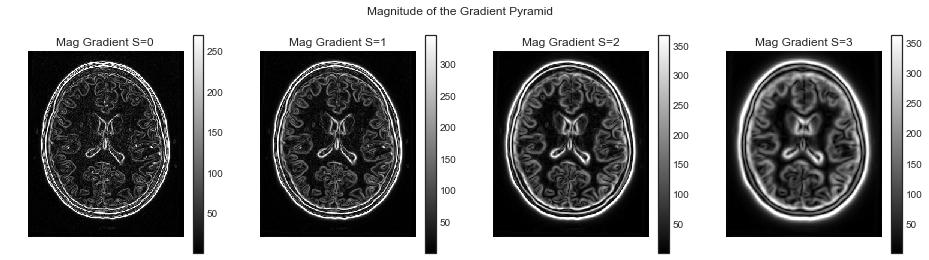

In [7]:
grad_pyr = gradient_pyramid(data, nlevels=4)
nlevels = len(grad_pyr)
norientations = len(grad_pyr[0])

mag_grad_pyr = []
for level in range(nlevels):
    temp = np.zeros(grad_pyr[level][0].shape, grad_pyr[level][0].dtype)
    for orient in range(norientations):
        temp += np.abs(grad_pyr[level][orient])**2
    mag_grad_pyr.append(np.sqrt(temp))

plt.figure(figsize=[nlevels*4, norientations*4])
plt.suptitle('Gradient Pyramid')
count = 0
for orient in range(norientations):
    for level in range(nlevels):
        im_show_scale(grad_pyr[level][orient], norientations,nlevels,count+1, 'Gradient S={}, O={}'.format(level,orient))
        count += 1

plt.figure(figsize=[nlevels*4,4])
plt.suptitle('Magnitude of the Gradient Pyramid')
for level in range(nlevels):
    im_show_scale(mag_grad_pyr[level], 1,nlevels,level+1, 'Mag Gradient S={}'.format(level))



## Do it all at once

In [8]:
t, names = textures(data, nlevels=4)

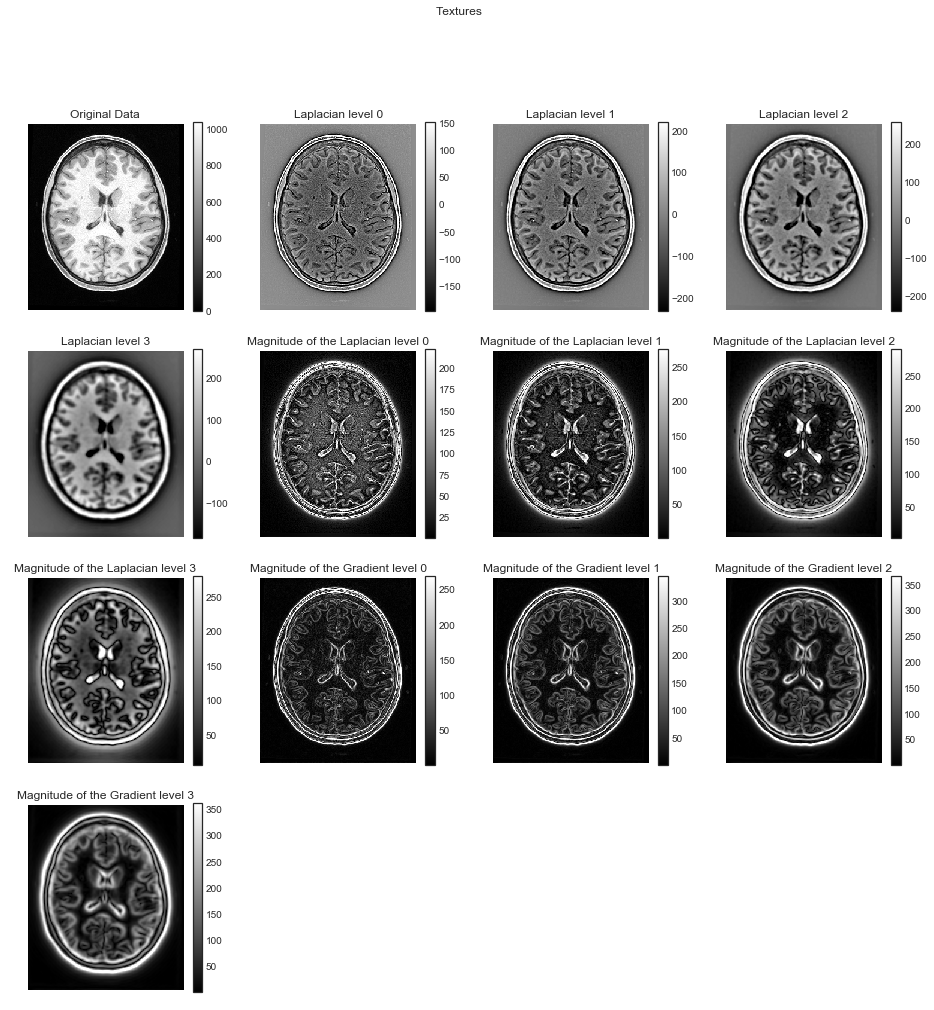

In [9]:
nfeats = len(t)
ncols = 4
nrows = ceil(nfeats/ncols)
plt.figure(figsize=[ncols*4, nrows*4])
plt.suptitle('Textures')
for n in range(nfeats):
    im_show_scale(t[n], nrows,ncols,n+1, names[n])


## Covariance

In [21]:
nvox = np.prod(data.shape)
T = np.zeros([nvox, nfeats], data.dtype)
for n in range(nfeats):
    T[:,n] = t[n].ravel()

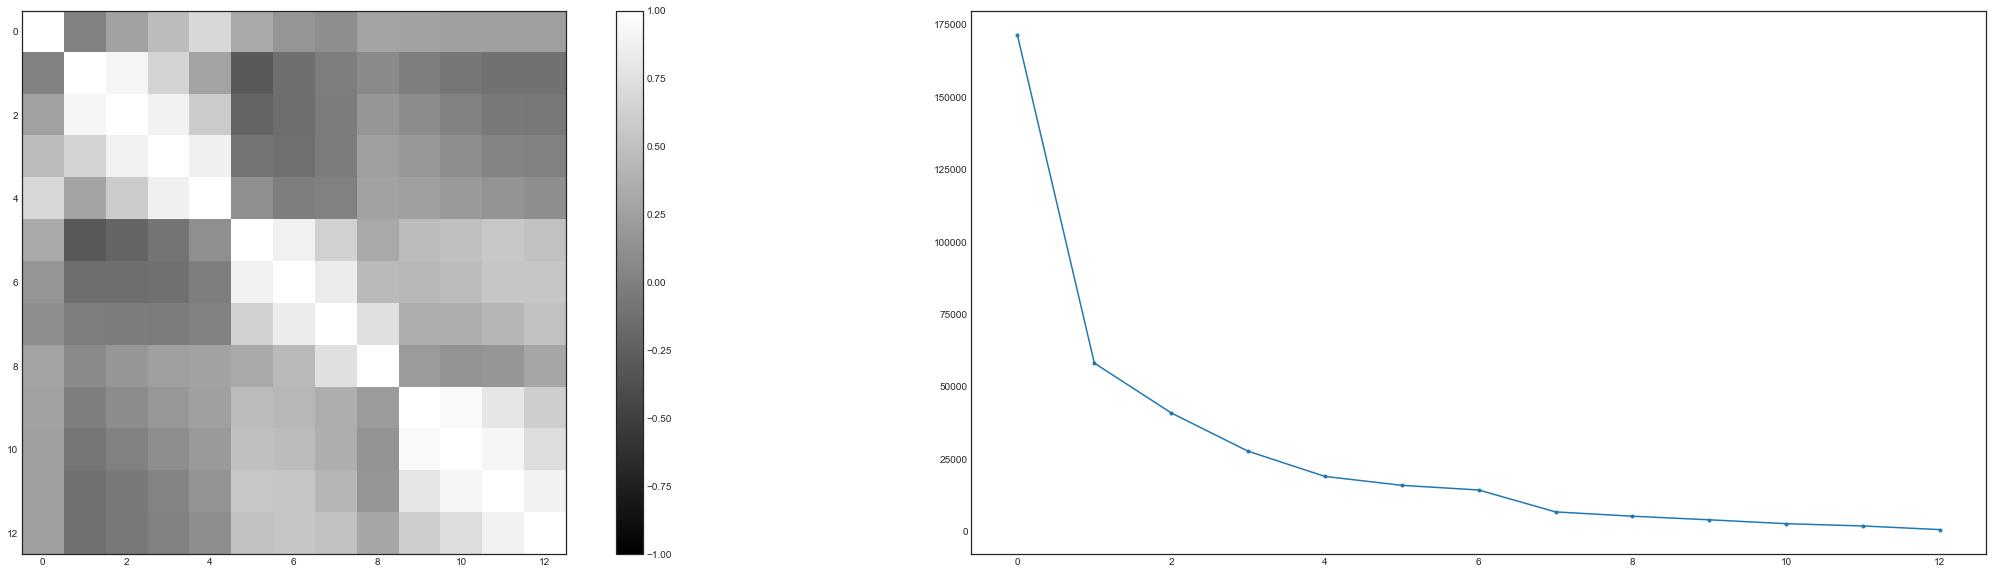

In [22]:
F = T
C = np.corrcoef(F, rowvar=False)
s = np.linalg.svd(F, compute_uv=False, full_matrices=False)

plt.figure(figsize=[40,10])
plt.subplot(1,2,1)
plt.imshow(C, cmap='gray', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(s, '.-')

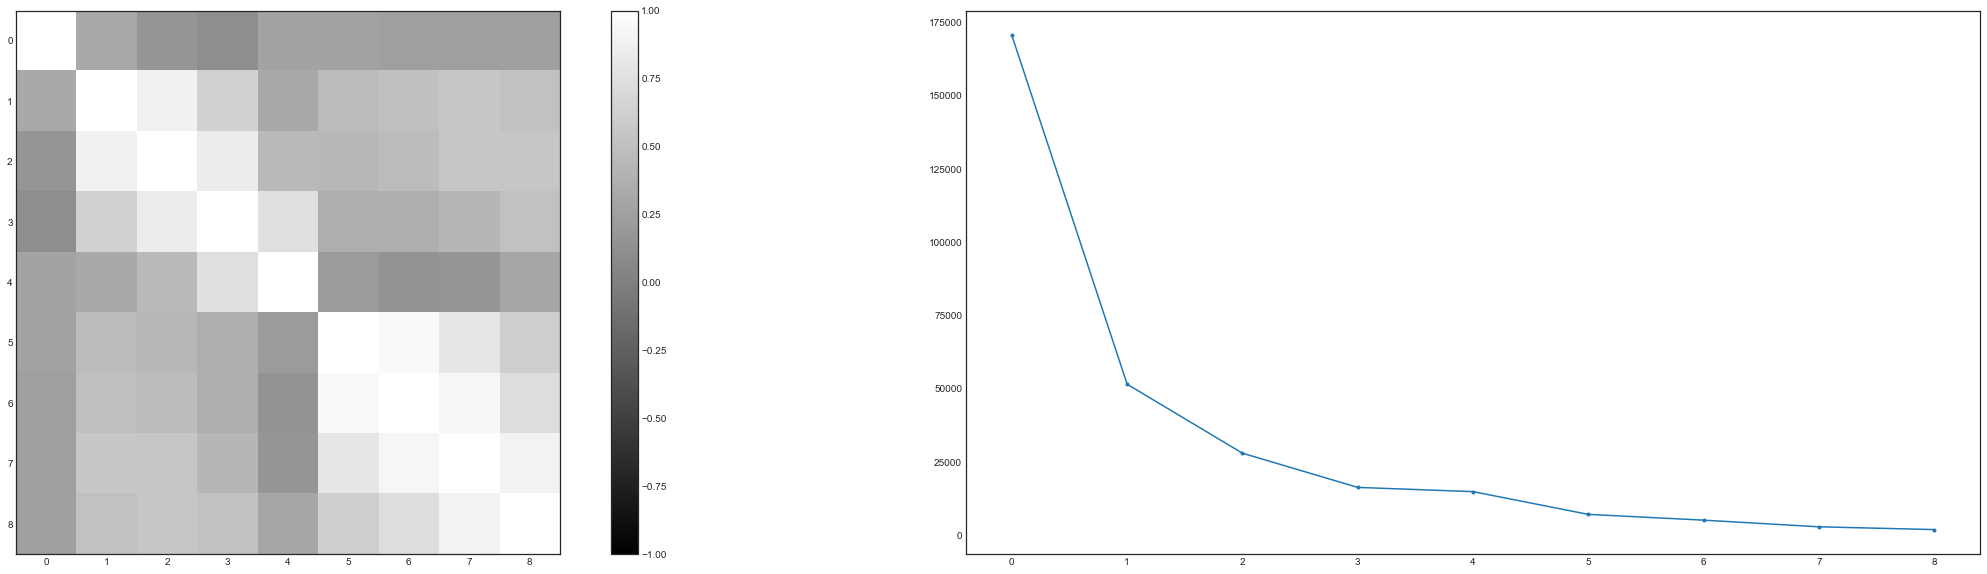

In [23]:
F = T[:,[0, 5,6,7,8,9,10,11,12]]
C = np.corrcoef(F, rowvar=False)
s = np.linalg.svd(F, compute_uv=False, full_matrices=False)

plt.figure(figsize=[40,10])
plt.subplot(1,2,1)
plt.imshow(C, cmap='gray', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(s, '.-')

In [24]:
[data.shape nfeats

13